# Predictive Model on Spotify Dataset

Link to spotify dataset: https://www.kaggle.com/theoverman/the-spotify-hit-predictor-dataset

## Import Data

In [2]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(24)

import os
import glob

import requests
import json
import time
import math
import collections

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [0]:
all_filenames = [x for x in glob.glob('*.{}'.format('csv'))]
all_filenames

['combined_dataset_of_60s_to_10s.csv',
 'dataset-of-00s.csv',
 'dataset-of-10s.csv',
 'dataset-of-60s.csv',
 'dataset-of-70s.csv',
 'dataset-of-80s.csv',
 'dataset-of-90s.csv']

In [0]:
# Combine all csv files and output a single csv file that contains all the data

# Commenting out this code as the files have been combined and outputted. 

# import re

#combined = []
#for file in all_filenames:
#    df = pd.read_csv(file)
#    df['source'] = re.findall("(\d+)", file)[0]+'s'
#    combined.append(df)
#combined_csv = pd.concat(combined)
#combined_csv.to_csv("combined_dataset_of_60s_to_10s.csv")

In [2]:
all_data = pd.read_csv("combined_dataset_of_60s_to_10s.csv")  
all_data.head(2)

,Unnamed: 0,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,...,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,source
0,0,Lucky Man,Montgomery Gentry,spotify:track:4GiXBCUF7H6YfNQsnBRIzl,0.578,0.471,4,-7.270,1,0.0289,...,0.0,0.159,0.532,133.061,196707,4,30.88059,13,1,00s
1,1,On The Hotline,Pretty Ricky,spotify:track:1zyqZONW985Cs4osz9wlsu,0.704,0.854,10,-5.477,0,0.1830,...,0.0,0.148,0.688,92.988,242587,4,41.51106,10,1,00s


## Data Preparation and Preliminary Analysis

In [93]:
dataset = all_data.copy()

# Dropping the "Unnamed: 0" / index column as it is no longer useful

dataset = dataset.loc[:, 'track':]
dataset.head(2)

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,source
0,Lucky Man,Montgomery Gentry,spotify:track:4GiXBCUF7H6YfNQsnBRIzl,0.578,0.471,4,-7.270,1,0.0289,0.3680,0.0,0.159,0.532,133.061,196707,4,30.88059,13,1,00s
1,On The Hotline,Pretty Ricky,spotify:track:1zyqZONW985Cs4osz9wlsu,0.704,0.854,10,-5.477,0,0.1830,0.0185,0.0,0.148,0.688,92.988,242587,4,41.51106,10,1,00s


In [0]:
dataset.shape

(41106, 20)

In [17]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41106 entries, 0 to 41105
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track             41106 non-null  object 
 1   artist            41106 non-null  object 
 2   uri               41106 non-null  object 
 3   danceability      41106 non-null  float64
 4   energy            41106 non-null  float64
 5   key               41106 non-null  int64  
 6   loudness          41106 non-null  float64
 7   mode              41106 non-null  int64  
 8   speechiness       41106 non-null  float64
 9   acousticness      41106 non-null  float64
 10  instrumentalness  41106 non-null  float64
 11  liveness          41106 non-null  float64
 12  valence           41106 non-null  float64
 13  tempo             41106 non-null  float64
 14  duration_ms       41106 non-null  int64  
 15  time_signature    41106 non-null  int64  
 16  chorus_hit        41106 non-null  float6

In [0]:
dataset.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target
count,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,41106.000000,4.110600e+04,41106.000000,41106.000000,41106.000000,41106.000000
mean,0.539695,0.579545,5.213594,-10.221525,0.693354,0.072960,0.364197,0.154416,0.201535,0.542440,119.338249,2.348776e+05,3.893689,40.106041,10.475673,0.500000
std,0.177821,0.252628,3.534977,5.311626,0.461107,0.086112,0.338913,0.303530,0.172959,0.267329,29.098845,1.189674e+05,0.423073,19.005515,4.871850,0.500006
min,0.000000,0.000251,0.000000,-49.253000,0.000000,0.000000,0.000000,0.000000,0.013000,0.000000,0.000000,1.516800e+04,0.000000,0.000000,0.000000,0.000000
25%,0.420000,0.396000,2.000000,-12.816000,0.000000,0.033700,0.039400,0.000000,0.094000,0.330000,97.397000,1.729278e+05,4.000000,27.599793,8.000000,0.000000
50%,0.552000,0.601000,5.000000,-9.257000,1.000000,0.043400,0.258000,0.000120,0.132000,0.558000,117.565000,2.179070e+05,4.000000,35.850795,10.000000,0.500000
75%,0.669000,0.787000,8.000000,-6.374250,1.000000,0.069800,0.676000,0.061250,0.261000,0.768000,136.494000,2.667730e+05,4.000000,47.625615,12.000000,1.000000
max,0.988000,1.000000,11.000000,3.744000,1.000000,0.960000,0.996000,1.000000,0.999000,0.996000,241.423000,4.170227e+06,5.000000,433.182000,169.000000,1.000000


# Spotify Track Genre, JSON parsing

In [325]:
"""
s_key expired, get new one at
https://developer.spotify.com/console/get-several-artists/?ids=0oSGxfWSnnOXhD2fKuz2Gy,3dBVyJ7JuOMt4GE9607Qin
"""
s_key = 'BQDK4Dt1Q8tOuIaCSZVx1bau_bOM7xjoJHuV59RPdFoMkJaxLrTb_pnypZygGAdNjshnQEIb_YE6XatULr6HH-SAME540IKJumKRAGU0MUcBU_6IKMY7Z_uX8PWDpNbVfKkUU2Im'
spotify_key = 'Bearer ' + s_key
def getArtist(track_id):
    track_url = 'https://api.spotify.com/v1/tracks/'
    track_id = str(track_id) + '?market=US'

    header = {'Authorization': spotify_key, 'Content-Type': 'application/json'}
    param = {'market':'US'}
    full_url = track_url + track_id

    track_temp = requests.get(full_url, headers=header)
    temp_txtt = json.loads(track_temp.text)
    *_, artist_id = temp_txtt['album']['artists'][0]['uri'].split(':')
    return artist_id

In [163]:
def genreFromTrack(track_id):
    track_url = 'https://api.spotify.com/v1/tracks/'
    track_id = str(track_id) + '?market=US'

    header = {'Authorization': spotify_key, 'Content-Type': 'application/json'}
    param = {'market':'US'}
    full_url = track_url + track_id

    track_temp = requests.get(full_url, headers=header)
    temp_txtt = json.loads(track_temp.text)
    *_, artist_id = temp_txtt['album']['artists'][0]['uri'].split(':')
    artist_url = 'https://api.spotify.com/v1/artists/'
    artist_temp = requests.get(artist_url+artist_id, headers=header)

    temp_genre = json.loads(artist_temp.text)
    return temp_genre['genres']

In [215]:
def trackToArtistList(track_id_list):
    track_url = 'https://api.spotify.com/v1/tracks'
    track_id = '?ids='
    for l in track_id_list:
        track_id += str(l) + '%2C'
    track_id = track_id[:-3]

    header = {'Authorization': spotify_key, 'Content-Type': 'application/json'}
    param = {'market':'US'}
    full_url = track_url + track_id

    track_temp = requests.get(full_url, headers=header, params = param)
    temp_txtt = json.loads(track_temp.text)
    """*_, artist_id = temp_txtt['album']['artists'][0]['uri'].split(':')
    artist_url = 'https://api.spotify.com/v1/artists/'
    artist_temp = requests.get(artist_url+artist_id, headers=header)

    temp_genre = json.loads(artist_temp.text)"""
    return temp_txtt

In [276]:
def artistToGenreList(artist_id_list):
    artist_url = 'https://api.spotify.com/v1/artists'
    artist_id = '?ids='
    for l in artist_id_list:
        artist_id += str(l) + '%2C'
    artist_id = artist_id[:-3]

    header = {'Authorization': spotify_key, 'Content-Type': 'application/json'}
    full_url = artist_url + artist_id

    track_temp = requests.get(full_url, headers=header)
    temp_txtt = json.loads(track_temp.text)
    return temp_txtt

In [340]:
track_id_list = []
for uri in dataset['uri'].values:
    *_, tmp_uri = uri.split(':')
    track_id_list.append(tmp_uri)

## Insert Genre for Track in Table

In [224]:
splits_num = math.ceil(len(dataset)/50) #trackToArtistList can only handle 50 requests at a time, limited by spotify

In [228]:
track_id_list_tmp = np.array_split(np.array(track_id_list), splits_num)

In [246]:
artist_ids = []
for i in track_id_list_tmp:
    tmp_r = trackToArtistList(i)
    for n in tmp_r['tracks']:
        *_, tmp_uri = n['album']['artists'][0]['uri'].split(':')
        artist_ids.append(tmp_uri)

In [248]:
len(artist_ids)

41106

In [241]:
"""artist_id_list = []
for n in artist_id_resp['tracks']:
    *_, tmp_uri = n['album']['artists'][0]['uri'].split(':')
    artist_id_list.append(tmp_uri)"""

In [253]:
artist_id_list = np.array_split(np.array(artist_ids), splits_num)

In [332]:
genres_list = []
for i in artist_id_list:
    tmp_r = artistToGenreList(i)
    for n in tmp_r['artists']:
        genres_list.append(n['genres'])

In [333]:
len(genres_list)

41106

In [331]:
tmp_r = artistToGenreList(['3bGXaFVQLASmDMdjjeJr8a','6XwcepfAsPhrvwziGxhwju','7zDtfSB0AOZWhpuAHZIOw5'])
lil_list = []
for n in tmp_r['artists']:
    lil_list.append(n['genres'])
lil_list

[['contemporary country',
  'country',
  'country road',
  'modern country rock',
  'redneck'],
 ['dance pop',
  'deep pop r&b',
  'hip hop',
  'hip pop',
  'miami hip hop',
  'pop rap',
  'r&b',
  'rap',
  'southern hip hop',
  'trap',
  'urban contemporary'],
 ['death metal',
  'doom metal',
  'epic doom',
  'groove metal',
  'hard rock',
  'metal',
  'speed metal',
  'stoner metal',
  'stoner rock',
  'swedish doom metal',
  'swedish metal',
  'thrash metal']]

In [449]:
dave_df = dataset.copy()

In [450]:
#track_id_list
dave_df.head()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,source
0,Lucky Man,Montgomery Gentry,spotify:track:4GiXBCUF7H6YfNQsnBRIzl,0.578,0.471,4,-7.270,1,0.0289,0.368000,0.00000,0.159,0.532,133.061,196707,4,30.88059,13,1,00s
1,On The Hotline,Pretty Ricky,spotify:track:1zyqZONW985Cs4osz9wlsu,0.704,0.854,10,-5.477,0,0.1830,0.018500,0.00000,0.148,0.688,92.988,242587,4,41.51106,10,1,00s
2,Clouds Of Dementia,Candlemass,spotify:track:6cHZf7RbxXCKwEkgAZT4mY,0.162,0.836,9,-3.009,1,0.0473,0.000111,0.00457,0.174,0.300,86.964,338893,4,65.32887,13,0,00s
3,"Heavy Metal, Raise Hell!",Zwartketterij,spotify:track:2IjBPp2vMeX7LggzRN3iSX,0.188,0.994,4,-3.745,1,0.1660,0.000007,0.07840,0.192,0.333,148.440,255667,4,58.59528,9,0,00s
4,I Got A Feelin',Billy Currington,spotify:track:1tF370eYXUcWwkIvaq3IGz,0.630,0.764,2,-4.353,1,0.0275,0.363000,0.00000,0.125,0.631,112.098,193760,4,22.62384,10,1,00s


## Merge genre into existing DataFrame

In [451]:
tmp_data = {
    'track_uri':track_id_list,
    'genres':genres_list
}

In [452]:
genres_df = pd.DataFrame(tmp_data)

In [453]:
genres_df

,track_uri,genres
0,4GiXBCUF7H6YfNQsnBRIzl,"[contemporary country, country, country road, ..."
1,1zyqZONW985Cs4osz9wlsu,"[dance pop, deep pop r&b, hip hop, hip pop, mi..."
2,6cHZf7RbxXCKwEkgAZT4mY,"[death metal, doom metal, epic doom, groove me..."
3,2IjBPp2vMeX7LggzRN3iSX,[dutch black metal]
4,1tF370eYXUcWwkIvaq3IGz,"[contemporary country, country, country road, ..."
...,...,...
41101,4e86fqSFhqRQk3Z9hm7XHt,[nyhc]
41102,43DFcnOZprnVlAFKwgBJ3e,"[latin alternative, latin rock, mexican rock, ..."
41103,6UPfnVoOq3y3BvapBIKs8J,"[folk, lilith]"
41104,2Ao3Wi4raEOQfKQiU9EU8y,"[cyberpunk, ebm, electro-industrial, industria..."


In [454]:
tmp_df = dave_df['uri'].str.rsplit(':', n=1, expand=True).rename(columns={1:'t_uri'})['t_uri']
dave_df['t_uri'] = tmp_df

In [156]:
dave_df = dave_df.merge(genres_df, left_on = 't_uri', right_on = 'track_uri')

NameError: name 'dave_df' is not defined

In [462]:
dave_df.drop(['t_uri','track_uri'], axis=1, inplace=True)
dave_df.head(2)

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,source,genres
0,Lucky Man,Montgomery Gentry,spotify:track:4GiXBCUF7H6YfNQsnBRIzl,0.578,0.471,4,-7.270,1,0.0289,0.3680,...,0.159,0.532,133.061,196707,4,30.88059,13,1,00s,"[contemporary country, country, country road, ..."
1,On The Hotline,Pretty Ricky,spotify:track:1zyqZONW985Cs4osz9wlsu,0.704,0.854,10,-5.477,0,0.1830,0.0185,...,0.148,0.688,92.988,242587,4,41.51106,10,1,00s,"[dance pop, deep pop r&b, hip hop, hip pop, mi..."


In [463]:
dave_df.to_csv('dave_df.csv', index=False)

In [249]:
genres_df = pd.read_csv('dave_df.csv')

In [250]:
genres_df.head(2)

,Unnamed: 0,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,...,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,source,genres
0,0,Lucky Man,Montgomery Gentry,spotify:track:4GiXBCUF7H6YfNQsnBRIzl,0.578,0.471,4,-7.270,1,0.0289,...,0.159,0.532,133.061,196707,4,30.88059,13,1,00s,"['contemporary country', 'country', 'country r..."
1,1,On The Hotline,Pretty Ricky,spotify:track:1zyqZONW985Cs4osz9wlsu,0.704,0.854,10,-5.477,0,0.1830,...,0.148,0.688,92.988,242587,4,41.51106,10,1,00s,"['dance pop', 'deep pop r&b', 'hip hop', 'hip ..."


## Convert genres list into single genre string

In [125]:
genres_list = []
for gen in genres_df['genres'].values:
    if gen == '[]':
        genres_list.append('N/A')
    else:
        x = gen[1:-1]
        x = x.replace('\'','')
        x = x.split(', ')
        for i in x:
            genres_list.append(i)

In [128]:
genres_count = collections.Counter()

for gen in genres_list:
    genres_count[gen] += 1

In [133]:
genres_count.most_common(20)

[('N/A', 4692),
 ('mellow gold', 3777),
 ('rock', 3690),
 ('soft rock', 3660),
 ('adult standards', 3361),
 ('folk rock', 3177),
 ('classic rock', 2939),
 ('dance pop', 2776),
 ('brill building pop', 2668),
 ('album rock', 2638),
 ('pop', 2460),
 ('soul', 2392),
 ('motown', 2242),
 ('quiet storm', 2051),
 ('pop rap', 2002),
 ('funk', 1948),
 ('urban contemporary', 1909),
 ('rap', 1864),
 ('country rock', 1842),
 ('bubblegum pop', 1815)]

In [140]:
genres_popular = []

for gen in genres_df['genres'].values:
    
    if gen == '[]':
        genres_popular.append('N/A')
    else:
        x = gen[1:-1]
        x = x.replace('\'','')
        x = x.split(', ')
        tmp_dict = collections.defaultdict()
        for i in x:
            tmp_dict[i] = genres_count[i]
        max_key = max(tmp_dict, key=tmp_dict.get)
        genres_popular.append(i)

In [265]:
tmp_df = pd.DataFrame(genres_popular, columns=['genre'])
tmp_df.head(2)

,genre
0,redneck
1,urban contemporary


In [266]:
tmp_df['genre'].head(2)

0               redneck
1    urban contemporary
Name: genre, dtype: object

In [267]:
genres_df['genres'].head(2)

0    ['contemporary country', 'country', 'country r...
1    ['dance pop', 'deep pop r&b', 'hip hop', 'hip ...
Name: genres, dtype: object

In [268]:
genres_df = genres_df.join(tmp_df)

In [269]:
genres_df.drop('genres', axis=1, inplace=True)

In [270]:
genres_df.head(2)

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,source,genre
0,Lucky Man,Montgomery Gentry,spotify:track:4GiXBCUF7H6YfNQsnBRIzl,0.578,0.471,4,-7.270,1,0.0289,0.3680,...,0.159,0.532,133.061,196707,4,30.88059,13,1,00s,redneck
1,On The Hotline,Pretty Ricky,spotify:track:1zyqZONW985Cs4osz9wlsu,0.704,0.854,10,-5.477,0,0.1830,0.0185,...,0.148,0.688,92.988,242587,4,41.51106,10,1,00s,urban contemporary


In [271]:
genres_df.to_csv('genres_df.csv', index=False)

## Most popular Genres

In [3]:
genres_df = pd.read_csv('genres_df.csv')

In [5]:
genres_df.set_index('genre').loc['redneck'].head(2)

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,source
genre,,,,,,,,,,,,,,,,,,,,
redneck,Lucky Man,Montgomery Gentry,spotify:track:4GiXBCUF7H6YfNQsnBRIzl,0.578,0.471,4,-7.270,1,0.0289,0.368,0.000000,0.1590,0.532,133.061,196707,4,30.88059,13,1,00s
redneck,Daddy Won't Sell The Farm,Montgomery Gentry,spotify:track:2Wt173KM9i97KSB52qCuqj,0.708,0.728,7,-7.039,1,0.0298,0.011,0.000023,0.0556,0.704,119.881,258640,4,33.81641,15,1,00s


In [6]:
genres_df.isna().values.any()

True

In [7]:
g = genres_df[~genres_df['genre'].isna()]

In [8]:
g_count = g.groupby('genre')['track'].count().sort_values(ascending=False)

In [9]:
g_count[g_count > 300]

genre
soft rock                     2218
urban contemporary            1865
rock                          1310
soul                          1021
southern soul                  933
post-teen pop                  654
trap                           653
yacht rock                     626
traditional folk               610
vocal jazz                     604
country road                   554
rap                            518
symphonic rock                 441
rock-and-roll                  429
soundtrack                     410
modern country rock            408
rockabilly                     394
lounge                         363
pop rock                       347
synthpop                       337
vintage italian soundtrack     333
pop                            319
zolo                           319
uk post-punk                   303
Name: track, dtype: int64

Text(0, 0.5, 'Number of Occurrences')

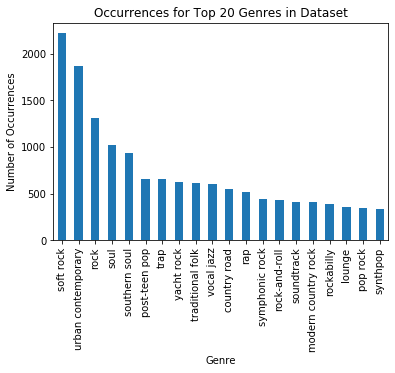

In [12]:
g_count[g_count >= 337].plot(kind='bar')
plt.title('Occurrences for Top 20 Genres in Dataset')
plt.xlabel('Genre')
plt.ylabel('Number of Occurrences')

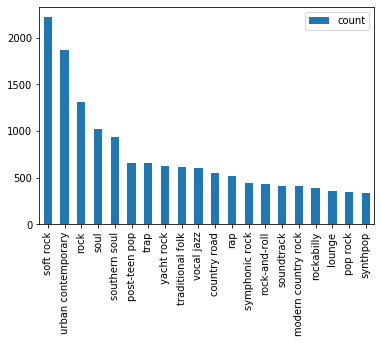

In [169]:
tmp = collections.Counter(g['genre'])
tmp = tmp.most_common(20)
tmp = pd.DataFrame(data=tmp, index=[item[0] for item in tmp], columns=['genre','count'])
tmp.drop('genre', axis=1)
tmp.plot(kind='bar')

# Classifiers

In [204]:
d_df = pd.read_csv("combined_dataset_of_60s_to_10s.csv")

In [206]:
d_df = d_df.drop('Unnamed: 0', axis=1)

In [207]:
d_df.head(2)

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,source
0,Lucky Man,Montgomery Gentry,spotify:track:4GiXBCUF7H6YfNQsnBRIzl,0.578,0.471,4,-7.270,1,0.0289,0.3680,0.0,0.159,0.532,133.061,196707,4,30.88059,13,1,00s
1,On The Hotline,Pretty Ricky,spotify:track:1zyqZONW985Cs4osz9wlsu,0.704,0.854,10,-5.477,0,0.1830,0.0185,0.0,0.148,0.688,92.988,242587,4,41.51106,10,1,00s


## K-Nearest Neighbors

In [248]:
X_train, X_test, Y_train, Y_test = train_test_split(d_df.drop(['track','artist','uri','source','target'],axis=1),
                                                    d_df['target'], test_size=0.2, random_state=24)

grid_params_knn = {
    'n_neighbors':[15,19,23,29],
    'weights':['uniform','distance'],
    'metric':['euclidean','manhattan','minkowski']
}

knn = GridSearchCV(
    KNeighborsClassifier(),
    grid_params_knn,
    cv=5,
    verbose=1,
    n_jobs=-1
)

knn_results = knn.fit(X_train, Y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    7.6s finished


In [249]:
knn_results.best_score_

0.5947877387179176

In [250]:
knn_results.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=29, p=2,
                     weights='distance')

In [251]:
knn_results.best_params_

{'metric': 'manhattan', 'n_neighbors': 29, 'weights': 'distance'}

The k-nearest neighbors model with the best accuracy is with the parameters above. As will see this not a great model as other classifiers will do better below, however it does better linear SVC.

## Linear SVC

In [252]:
grid_params_svc = {
    'C':[1,10,100,1000,10000]
}

svc = GridSearchCV(
    LinearSVC(),
    grid_params_svc,
    cv=5,
    verbose=1,
    n_jobs=-1
)

svc_results = svc.fit(X_train, Y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   22.0s finished
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [253]:
svc_results.best_score_

0.5167254591898796

In [254]:
svc_results.best_estimator_

LinearSVC(C=100, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [255]:
svc_results.best_params_

{'C': 100}

This accuracy is worse than the knn model above, and will certaintly not be used for this project.

## Decision Tree Classifier

In [261]:
grid_params_dtc = {
    'criterion':['gini','entropy'],
    'splitter':['random','best'],
    'max_depth':[5,6,7,8,9],
    'min_samples_split':[2,3,4,5]
}

dtc = GridSearchCV(
    DecisionTreeClassifier(),
    grid_params_dtc,
    cv=5,
    verbose=1,
    n_jobs=-1
)

dtc_results = dtc.fit(X_train, Y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   11.7s finished


In [262]:
dtc_results.best_score_

0.7579674005595426

In [263]:
dtc_results.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [264]:
dtc_results.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'min_samples_split': 2,
 'splitter': 'best'}

The decision tree classifier model with the best accuracy is with the parameters above. This is a much better model than the classifiers above since the accuracy for prediction is around 76.8% and now for the final model investigated here.

## Random Forest Classifier

In [265]:
grid_params_rfc = {
    'n_estimators':[10,50,100,150,200],
    'criterion':['gini','entropy'],
    'max_depth':[None,1,2,3,4,5],
    'min_samples_split':[2,3,4,5]
}

rfc = GridSearchCV(
    RandomForestClassifier(),
    grid_params_rfc,
    cv=5,
    verbose=1,
    n_jobs=-1
)

rfc_results = rfc.fit(X_train, Y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 12.6min finished


In [266]:
rfc_results.best_score_

0.7882860965819244

In [267]:
rfc_results.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [268]:
rfc_results.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_split': 3,
 'n_estimators': 150}

The random forest classifier model with the best accuracy is with the parameters above. This is so far the best model with an accuracy of 78.8% predicting if a track will be a flop or not.

In [291]:
pd.DataFrame.from_dict(rfc_results.cv_results_).head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.933173,0.020386,0.025411,0.001967,gini,None,2,10,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.764366,0.752927,0.757640,0.762622,0.756235,0.758758,0.004195,73
1,4.591114,0.024604,0.098972,0.002787,gini,None,2,50,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.782153,0.774061,0.784856,0.788169,0.780870,0.782022,0.004702,32


In [287]:
import pickle

In [281]:
with open('randomforestclassifier_pickle.pickle', 'wb') as f:
    pickle.dump(rfc_results,f)

In [288]:
with open('randomforestclassifier_pickle.pickle', 'rb') as f:
    _tmp = pickle.load(f)
_tmp.best_score_

0.7882860965819244

In [293]:
grid_params_rfc_ = {
    'n_estimators':[100,125,150,175,200],
    'criterion':['gini','entropy'],
    'max_depth':[None,1,2,3,4,5],
    'min_samples_split':[2,3,4,5]
}

rfc_ = GridSearchCV(
    RandomForestClassifier(),
    grid_params_rfc_,
    cv=5,
    verbose=1,
    n_jobs=-1
)

rfc_results_ = rfc_.fit(X_train, Y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 18.5min finished


In [294]:
rfc_results_.best_score_

0.7869176499209342

In [296]:
rfc_results_.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [295]:
rfc_results_.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_split': 4,
 'n_estimators': 200}

In [51]:
genres_df = pd.read_csv('genres_df.csv')

In [44]:
genres_df.head(2)

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,source,genre
0,Lucky Man,Montgomery Gentry,spotify:track:4GiXBCUF7H6YfNQsnBRIzl,0.578,0.471,4,-7.270,1,0.0289,0.3680,...,0.159,0.532,133.061,196707,4,30.88059,13,1,00s,redneck
1,On The Hotline,Pretty Ricky,spotify:track:1zyqZONW985Cs4osz9wlsu,0.704,0.854,10,-5.477,0,0.1830,0.0185,...,0.148,0.688,92.988,242587,4,41.51106,10,1,00s,urban contemporary


In [45]:
tmp_df = pd.get_dummies(genres_df['genre'], prefix='genre')

In [46]:
dummy_df = genres_df.join(tmp_df).drop('genre',axis=1)

In [47]:
dummy_df.head(2)

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,genre_wyoming indie,genre_wyoming roots,genre_xhosa,genre_yacht rock,genre_ye ye,genre_yodeling,genre_zapstep,genre_zeuhl,genre_zolo,genre_zydeco
0,Lucky Man,Montgomery Gentry,spotify:track:4GiXBCUF7H6YfNQsnBRIzl,0.578,0.471,4,-7.270,1,0.0289,0.3680,...,0,0,0,0,0,0,0,0,0,0
1,On The Hotline,Pretty Ricky,spotify:track:1zyqZONW985Cs4osz9wlsu,0.704,0.854,10,-5.477,0,0.1830,0.0185,...,0,0,0,0,0,0,0,0,0,0


## Random Forest Classifier on Dataframe with most popular Genre

In [409]:
X_tr, X_te, Y_tr, Y_te = train_test_split(dummy_df.drop(['track','artist','uri','source','target'],axis=1),
                                                    genres_df['target'], test_size=0.2, random_state=24)

In [410]:
grid_params_dummy = {
    'n_estimators':[150,200],
    'criterion':['entropy'],
    'max_depth':[None],
    'min_samples_split':[3,4]
}

rfc_dummy = GridSearchCV(
    RandomForestClassifier(),
    grid_params_dummy,
    cv=5,
    verbose=1,
    n_jobs=-1
)

rfc_dummy_results = rfc_dummy.fit(X_tr, Y_tr)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  3.2min finished


In [411]:
rfc_dummy_results.best_score_

0.8928698329977496

In [412]:
rfc_dummy_results.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [413]:
rfc_dummy_results.best_params_

{'criterion': 'entropy',
 'max_depth': None,
 'min_samples_split': 4,
 'n_estimators': 200}

In [416]:
pd.DataFrame.from_dict(rfc_dummy_results.cv_results_).head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,60.908820,0.310812,0.964530,0.027169,entropy,None,3,150,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.893708,0.893708,0.883346,0.890435,0.894862,0.891212,0.004202,4
1,80.349953,0.307280,1.302166,0.059512,entropy,None,3,200,"{'criterion': 'entropy', 'max_depth': None, 'm...",0.893264,0.893116,0.886899,0.893693,0.895454,0.892485,0.002915,2


In [425]:
rfc_dummy_results.best_estimator_.feature_importances_
dummy_df.drop(['track','artist','uri','source','target'],axis=1).columns.values

array(['danceability', 'energy', 'key', ..., 'genre_zeuhl', 'genre_zolo',
       'genre_zydeco'], dtype=object)

In [565]:
importance_dict_g = {}
z=0
for importance in dummy_df.drop(['track','artist','uri','source','target'],axis=1).columns.values:
    importance_dict_g[importance] = [rfc_dummy_results.best_estimator_.feature_importances_[z]]
    z+=1

In [566]:
"""_tmp = pd.DataFrame(rfc_dummy_results.best_estimator_.feature_importances_.reshape(1333,1).T,
                    columns=dummy_df.drop(['track','artist','uri','source','target'],axis=1).columns.values)"""

"_tmp = pd.DataFrame(rfc_dummy_results.best_estimator_.feature_importances_.reshape(1333,1).T,\n                    columns=dummy_df.drop(['track','artist','uri','source','target'],axis=1).columns.values)"

In [567]:
_tmp = pd.DataFrame.from_dict(importance_dic_)

NameError: name 'importance_dic_' is not defined

In [ ]:
_tmp.sort_values(by=0,axis=1,ascending=False) #check

In [52]:
tmp = genres_df.drop(['source'], axis=1)

In [53]:
tmp

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,genre
0,Lucky Man,Montgomery Gentry,spotify:track:4GiXBCUF7H6YfNQsnBRIzl,0.578,0.471,4,-7.270,1,0.0289,0.368000,0.000000,0.1590,0.532,133.061,196707,4,30.88059,13,1,redneck
1,On The Hotline,Pretty Ricky,spotify:track:1zyqZONW985Cs4osz9wlsu,0.704,0.854,10,-5.477,0,0.1830,0.018500,0.000000,0.1480,0.688,92.988,242587,4,41.51106,10,1,urban contemporary
2,Clouds Of Dementia,Candlemass,spotify:track:6cHZf7RbxXCKwEkgAZT4mY,0.162,0.836,9,-3.009,1,0.0473,0.000111,0.004570,0.1740,0.300,86.964,338893,4,65.32887,13,0,thrash metal
3,"Heavy Metal, Raise Hell!",Zwartketterij,spotify:track:2IjBPp2vMeX7LggzRN3iSX,0.188,0.994,4,-3.745,1,0.1660,0.000007,0.078400,0.1920,0.333,148.440,255667,4,58.59528,9,0,dutch black metal
4,I Got A Feelin',Billy Currington,spotify:track:1tF370eYXUcWwkIvaq3IGz,0.630,0.764,2,-4.353,1,0.0275,0.363000,0.000000,0.1250,0.631,112.098,193760,4,22.62384,10,1,modern country rock
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42211,(You're A) Go Nowhere,Reagan Youth,spotify:track:4e86fqSFhqRQk3Z9hm7XHt,0.396,0.795,9,-6.070,0,0.2340,0.000928,0.000209,0.1820,0.762,152.943,82107,4,30.34109,6,0,nyhc
42212,La Fiebre de Norma,La Castañeda,spotify:track:43DFcnOZprnVlAFKwgBJ3e,0.621,0.655,9,-6.281,0,0.0309,0.050600,0.006260,0.0937,0.690,134.167,211653,4,34.89506,10,0,rock urbano mexicano
42213,Good Times,Edie Brickell,spotify:track:6UPfnVoOq3y3BvapBIKs8J,0.562,0.314,10,-15.213,0,0.0298,0.440000,0.000011,0.1060,0.571,166.847,189827,4,21.11763,10,1,lilith
42214,Inane,KMFDM,spotify:track:2Ao3Wi4raEOQfKQiU9EU8y,0.622,0.781,7,-6.080,1,0.0368,0.000101,0.755000,0.3830,0.214,120.051,330053,4,47.13558,11,0,nu metal


In [54]:
tmp[tmp.duplicated()].track.count()

1530

In [488]:
rfc_results.best_estimator_.feature_importances_

array([0.10051205, 0.08368809, 0.03185985, 0.07864554, 0.0097515 ,
       0.07563722, 0.1083261 , 0.14752278, 0.05512681, 0.07291815,
       0.05810262, 0.07772234, 0.00634353, 0.05516144, 0.03868197])

In [514]:
col = d_df.drop(['track','artist','uri','source','target'],axis=1).columns
pd.DataFrame(rfc_results.best_estimator_.feature_importances_.reshape(15,1).T,
            columns=col).sort_values(by=0, axis=1, ascending=False)

,instrumentalness,acousticness,danceability,energy,loudness,duration_ms,speechiness,valence,tempo,chorus_hit,liveness,sections,key,mode,time_signature
0,0.147523,0.108326,0.100512,0.083688,0.078646,0.077722,0.075637,0.072918,0.058103,0.055161,0.055127,0.038682,0.03186,0.009751,0.006344


In [549]:
from decimal import Decimal

In [571]:
importance_dict = collections.defaultdict()
for feature, importance in zip(col,rfc_results.best_estimator_.feature_importances_):
    importance_dict[feature] = importance

In [609]:
for feature, importance in sorted(importance_dict.items(), key=lambda k: k[1], reverse=True):
    padding = '.'*(16-len(feature))
    print('{}{} Importance is {}%'.format(feature.title(),padding,float(round(Decimal(importance)*100,2))))

Instrumentalness Importance is 14.75%
Acousticness.... Importance is 10.83%
Danceability.... Importance is 10.05%
Energy.......... Importance is 8.37%
Loudness........ Importance is 7.86%
Duration_Ms..... Importance is 7.77%
Speechiness..... Importance is 7.56%
Valence......... Importance is 7.29%
Tempo........... Importance is 5.81%
Chorus_Hit...... Importance is 5.52%
Liveness........ Importance is 5.51%
Sections........ Importance is 3.87%
Key............. Importance is 3.19%
Mode............ Importance is 0.98%
Time_Signature.. Importance is 0.63%
